In [ ]:
import os
os.environ["VRE_LOGLEVEL"] = "0"
import torch as tr
import numpy as np
from pathlib import Path
import sys
from lightning_module_enhanced import LME, ModelAlgorithmOutput
from lightning_module_enhanced.utils import to_device
from omegaconf import DictConfig
from loggez import loggez_logger as logger
from vre.utils import (image_add_title, colorize_semantic_segmentation, image_resize, colorize_semantic_segmentation)
from vre import FFmpegVideo
from PIL import Image
from contexttimer import Timer

sys.path.append(Path.cwd().parents[1].__str__())
from models import build_model
from algorithms import build_algorithm

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def fix_batch_(batch: dict, missing_tasks: list[str]) -> dict:
    assert len(batch["data"]["rgb"]) == 1, batch["data"]["rgb"] # inference with bs=1 allowed for now only
    assert set(missing_tasks).issubset({"semantic_output", "depth_output", "camera_normals_output"}), missing_tasks
    if "semantic_output" in missing_tasks:
        batch["data"]["semantic_output"] = [tr.zeros(8, 540, 960)]
        batch["image_shape"][0]["semantic_output"] = 8
    if "depth_output" in missing_tasks:
        batch["data"]["depth_output"] = [tr.zeros(1, 540, 960)]
        batch["image_shape"][0]["depth_output"] = 1
    if "camera_normals_output" in missing_tasks:
        batch["data"]["camera_normals_output"] = [tr.zeros(3, 540, 960)]
        batch["image_shape"][0]["camera_normals_output"] = 3
    batch["data"] = {k: batch["data"][k] for k in sorted(batch["data"].keys())}
    batch["image_shape"] = [{k: batch["image_shape"][0][k] for k in sorted(batch["image_shape"][0].keys())}, ]
    return batch

def load_model_from_path(weights_path, device: str):
    data = tr.load(weights_path, map_location="cpu")
    cfg = DictConfig(data["hyper_parameters"]["cfg"])
    cfg.train.algorithm.metrics_only_on_masked = True
    model = LME(build_model(cfg).to(device).eval())
    model.load_state_dict(data["state_dict"])
    model.model_algorithm = build_algorithm(cfg.model.type, cfg.train.algorithm, loss_computer=None)
    model.hparams.cfg = cfg
    model.hparams.stats = data["hyper_parameters"]["statistics"]

    logger.info(f"Loaded '{cfg.model.type}' with {model.num_params} parameters on '{device}' from '{weights_path}'")
    logger.info(f"Excluded (fully masked) tasks: {cfg.train.algorithm.masking.parameters.excluded_tasks}")
    return model

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = tr.device("cuda") if tr.cuda.is_available() else tr.device("cpu")

# video_path = "rome_youtube_1_540p.mp4"
# video_path="poli_test.mp4"
video_path = "https://www.youtube.com/watch?v=QvrKOkLMiow"

# weights_path = "../../ckpts/safeuav/distil2/sl0-1M-ext2-distil/epoch=94-val_semantic_output_mean_iou=0.471.ckpt"
weights_path = "/home/mihai/code/ml/video-representations-extractor/resources/weights/semantic_segmentation/safeuav/model_430k.ckpt"
model = load_model_from_path(weights_path, device)
mean, std = model.hparams.stats["rgb"][2:4]

print(video_path)
video = FFmpegVideo(video_path, cache_len=0)
print(video)

[2025-02-25T22:44:37 INFO] Built masking algorithm: [RandomMasking] Tasks: ['rgb', 'semantic_output'] (excluded: ['semantic_output']), drop task(%): 50, drop patch(%): 0 (masking_algorithm.py:build_masking_algorithm:61)
[2025-02-25T22:44:37 INFO] Masking Algorithm:
[RandomMasking] Tasks: ['rgb', 'semantic_output'] (excluded: ['semantic_output']), drop task(%): 50, drop patch(%): 0 (__init__.py:build_algorithm:28)
[2025-02-25T22:44:37 INFO] Built Algorithm: 'mae_task_mask'. Params: {'type': 'mae_task_mask', 'patch_size': 'data_size', 'metrics_only_on_masked': True, 'masking': {'type': 'random_masking', 'parameters': {'tasks': ['rgb', 'semantic_output'], 'drop_task_percent': 50, 'drop_patch_percent': 0, 'excluded_tasks': ['semantic_output'], 'included_tasks': ['rgb']}}} (__init__.py:build_algorithm:37)
[2025-02-25T22:44:37 INFO] Loaded 'safeuav' with 438271 parameters on 'cuda' from '/home/mihai/code/ml/video-representations-extractor/resources/weights/semantic_segmentation/safeuav/model

https://www.youtube.com/watch?v=QvrKOkLMiow
[FFmpegVideo] Path: /tmp/https:/www.youtube.com/watch?v=QvrKOkLMiow.mp4. FPS: 25.0. Len: 3868. Frame shape: (1080, 1920, 3).


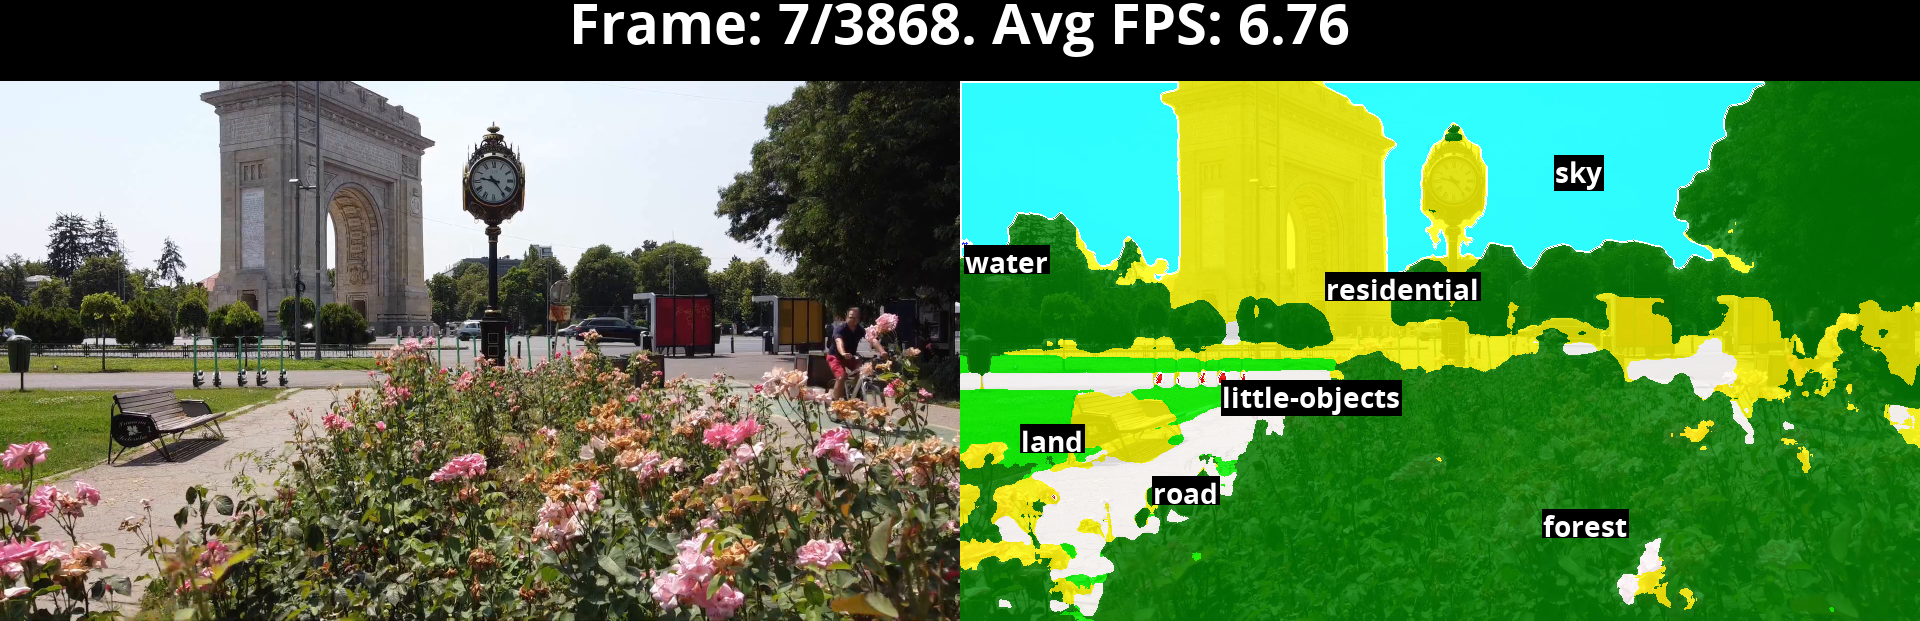

inference took 0.147 seconds


KeyboardInterrupt: 

In [ ]:
cfg = model.hparams.cfg
print(video)

@tr.no_grad()
def inference(model: LME, rgb: np.ndarray, mean: tuple[float, float, float],
              std: tuple[float, float, float]) -> np.ndarray:
    """inference on a single rgb [0:255] frame. Return semantic np array"""
    batch = {"data": {"rgb": [tr.from_numpy((rgb.astype(np.float32) - mean) / std).permute(2, 0, 1).float()]},
            "image_shape": [{"rgb": 3}]}
    batch = fix_batch_(batch, cfg.train.algorithm.masking.parameters.excluded_tasks)
    y_model: ModelAlgorithmOutput = to_device(model.model_algorithm(model, batch).y, "cpu")
    return y_model.pred["semantic_output"][0].numpy().argmax(0)

color_map = [[0, 255, 0], [0, 127, 0], [255, 255, 0], [255, 255, 255],
            [255, 0, 0], [0, 0, 255], [0, 255, 255], [127, 127, 63]]
classes_8 = ["land", "forest", "residential", "road", "little-objects", "water", "sky", "hill"]

i, timers = 0, []
while True:
    i += 1
    rgb = image_resize(video[ix := (i) % len(video)], height=540, width=960)
    with Timer(prefix="inference") as t:
        sema = inference(model, rgb, mean, std)
        sema_rgb = colorize_semantic_segmentation(sema[None], classes_8, color_map, rgb[None])[0]
    timers = [*timers[-10:], t.elapsed]
    img = image_add_title(np.concatenate([rgb, sema_rgb], axis=1),
                          f"Frame: {ix}/{len(video)}. Avg FPS: {len(timers) / sum(timers):.2f}", size_px=50)
    clear_output(wait=True)
    display(Image.fromarray(img))
